<a href="https://colab.research.google.com/github/sinchanMS12/Text-Summarization-and-Optimization/blob/main/memetic_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.2 MB/s eta 0:00:00


Dataset loaded with shape: (5435, 2)
First few rows of the dataset before preprocessing:
         Date  Google_Trends
0  2005-01-01             37
1  2005-01-02             68
2  2005-01-03             56
3  2005-01-04             82
4  2005-01-05             42
Dataset shape after dropping missing values: (5435, 2)
Feature shape: (5435, 3)
Target shape: (5435,)
Generation 1: Best fitness = 0.01655933762649494
Generation 2: Best fitness = 0.01655933762649494
Generation 3: Best fitness = 0.01655933762649494
Generation 4: Best fitness = 0.01655933762649494
Generation 5: Best fitness = 0.01655933762649494
Generation 6: Best fitness = 0.01655933762649494
Generation 7: Best fitness = 0.01655933762649494
Generation 8: Best fitness = 0.01655933762649494
Generation 9: Best fitness = 0.01655933762649494
Generation 10: Best fitness = 0.01655933762649494


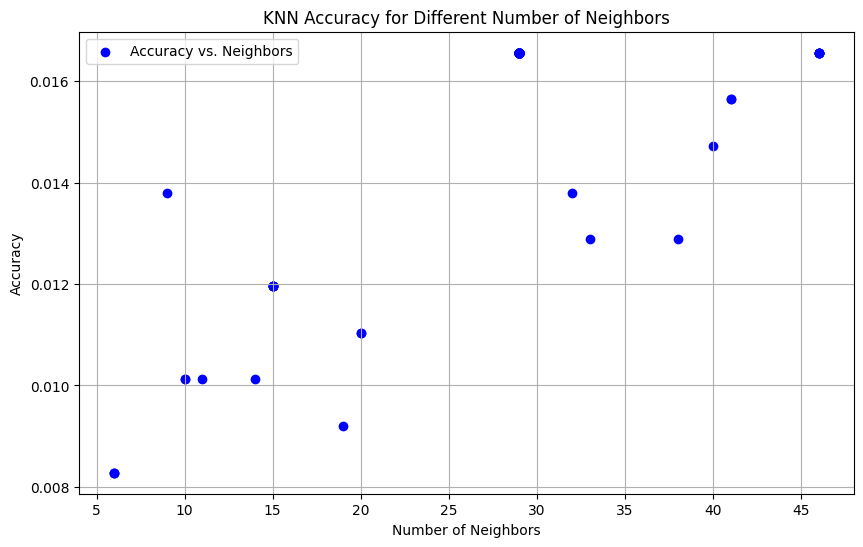

Optimal number of neighbors: 29
Accuracy with optimal number of neighbors: 0.02


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from deap import base, creator, tools, algorithms

# Step 1: Data Upload
def upload_data():
    file_path = "/content/amazon_trends.csv"
    dataset = pd.read_csv(file_path)
    print("Dataset loaded with shape:", dataset.shape)
    return dataset

# Step 2: Data Preprocessing
def preprocess_data(dataset):
    print("First few rows of the dataset before preprocessing:")
    print(dataset.head())

    dataset = dataset.dropna()
    print("Dataset shape after dropping missing values:", dataset.shape)

    if 'Date' in dataset.columns:
        dataset['Date'] = pd.to_datetime(dataset['Date'])
        dataset['Year'] = dataset['Date'].dt.year
        dataset['Month'] = dataset['Date'].dt.month
        dataset['Day'] = dataset['Date'].dt.day
        dataset = dataset.drop('Date', axis=1)

    for column in dataset.select_dtypes(include=['object']).columns:
        encoder = LabelEncoder()
        dataset[column] = encoder.fit_transform(dataset[column])

    X = dataset.iloc[:, :-1].values
    y = dataset.iloc[:, -1].values

    print("Feature shape:", X.shape)
    print("Target shape:", y.shape)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, y

# Step 3: Model Training and Evaluation
def evaluate_model(X, y, n_neighbors):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Local Search Function
def local_search(individual, X, y, search_radius=1):
    current_neighbors = int(individual[0])
    best_accuracy = evaluate_model(X, y, current_neighbors)

    # Explore neighbors in the search radius
    for neighbors in range(current_neighbors - search_radius, current_neighbors + search_radius + 1):
        if 1 <= neighbors <= 50:  # Ensure the number of neighbors is within the valid range
            accuracy = evaluate_model(X, y, neighbors)
            if accuracy > best_accuracy:
                individual[0] = neighbors
                best_accuracy = accuracy

    return individual,

# Memetic Algorithm for Optimization
def memetic_optimization(X, y):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_int", np.random.randint, 1, 50)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", lambda ind: (evaluate_model(X, y, int(round(ind[0]))),))
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=1, up=50, eta=1.0, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=10)
    ngen, cxpb, mutpb = 10, 0.5, 0.2

    # Register local search with the toolbox
    toolbox.register("local_search", local_search, X=X, y=y)

    accuracies = []
    neighbor_counts = []

    for gen in range(ngen):
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if np.random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if np.random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Apply local search to offspring
        for ind in offspring:
            ind, = toolbox.local_search(ind)

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        population[:] = offspring

        # Log the performance for analysis
        for ind in population:
            accuracy = evaluate_model(X, y, int(round(ind[0])))
            accuracies.append(accuracy)
            neighbor_counts.append(int(round(ind[0])))

        print(f"Generation {gen + 1}: Best fitness = {tools.selBest(population, 1)[0].fitness.values[0]}")

    plt.figure(figsize=(10, 6))
    plt.scatter(neighbor_counts, accuracies, c='blue', label='Accuracy vs. Neighbors')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.title('KNN Accuracy for Different Number of Neighbors')
    plt.legend()
    plt.grid(True)
    plt.show()

    best_individual = tools.selBest(population, 1)[0]
    return int(round(best_individual[0]))

# Main execution function
def main():
    dataset = upload_data()
    X, y = preprocess_data(dataset)
    optimal_neighbors = memetic_optimization(X, y)
    print(f"Optimal number of neighbors: {optimal_neighbors}")
    accuracy = evaluate_model(X, y, optimal_neighbors)
    print(f"Accuracy with optimal number of neighbors: {accuracy:.2f}")

if __name__ == "__main__":
    main()
